# LINEAR MACHINE LEARNING TECHNIQUES

In [2]:
# libraries
import pandas as pd 
import math
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn import linear_model

In [3]:
# In order to use this notebook for univarate time series analysis :-
# 1) The primary requirement is not to have missing values or categorial(string) data for time_dependent variable 
#    and time_column.
# 2) This cell requires information on file_name (only csv), time_dependent_variable, time_column, date_time format (frmt)
#    and resample grain(X). After filling the required information correctly, you can run all the cells (Cell ---> Run All)
# 3) Example :-
#   file_name               = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
#   time_dependent_variable = "Count"    (column name in your dataset)
#   time_column             = "Datetime" (column name in your dataset)
#   frmt                    = "%Y-%m-%d"
#   X                       = "D" 

file_name = "Monthly Production of Chocolate - Australia.csv"
time_dependent_variable = "Volume"
time_column = "Month"
frmt =  '%Y-%m'
X = "M"

### Reading the csv file

In [4]:
def data(time_column, file_name, frmt='%Y-%m-%d %H:%M:%S', X= "D"):
    df = pd.read_csv(file_name, parse_dates= True)
    df = df[[time_column,time_dependent_variable]]
    df[time_column] = pd.to_datetime(df[time_column],format=frmt) 
    df.index = df[time_column]
    df = df.resample(X).mean()
    df.reset_index(inplace= True)
    return df
df = data(time_column, file_name, frmt, X)

In [5]:
df.head()

,Month,Volume
0,1957-07-31,2953
1,1957-08-31,2635
2,1957-09-30,2404
3,1957-10-31,2413
4,1957-11-30,2136


## Defining the metrics

In [6]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

## Plot Function

In [7]:
def plot():
    plt.figure(figsize=(12,8))
    plt.plot(train.index, train[time_dependent_variable], label='Train')
    plt.plot(test.index,test[time_dependent_variable], label='Test')
    plt.plot(test.index,pred, label= 'forecast')
    plt.legend(loc='best')
    plt.title('forecast')
    plt.show()
    timeseries_evaluation_metrics_func(test_Y,pred)

## Feature Engineering
To use supervised machine learning, we need input and output variables. We can create features from a univariate time series in the following ways :-
- Date Time Features : These are components of the time step itself for each observation.
- Lag Features : These are values at prior time steps.
- Window Features : These are a summary of values over a fixed window of prior time steps.

let's try and explore each one of them...

#### 1) Date Time Features

In [8]:
def date_features(df):
    df['year'] = df[time_column].dt.year
    df['quarter'] = df[time_column].dt.quarter
    df['month'] = df[time_column].dt.month
    df['week_day'] = df[time_column].dt.weekday
    return df
df_date_features = date_features(df)[["year","quarter","month","week_day",time_dependent_variable]]

#### 2) Lag Features 

In [9]:
df_lag_features = pd.DataFrame()

def lag_features(n):
    df_lag_features["lag_{}".format(n)] = df[time_dependent_variable].shift(n)

Let's take lag = 1 and lag = 2 as features. It totally depends on your problem......

In [10]:
# if you want a different lag k just write lag_features(k) and the function would automatically do it for you..
lag_features(1)
lag_features(2)

#### 3) Window Features 

In [11]:
df_window_features = pd.DataFrame()

def rolling_mean(n):
    df_window_features["Rolling_mean_{}".format(n)] = df[time_dependent_variable].shift(1).rolling(window = n).mean()

Let's take rolling mean of 2 and 5. It totally depends on your problem.....

In [12]:
# if you want a different rolling mean k just write rolling_mean(k) and the function would automatically do it for you..
rolling_mean(2)
rolling_mean(5)

#### Combining the table with features 

In [13]:
df = pd.merge(pd.merge(df_date_features,df_lag_features,left_index=True,right_index=True),df_window_features,left_index=True, right_index=True)
df = df.dropna()
df.head()

,year,quarter,month,week_day,Volume,lag_1,lag_2,Rolling_mean_2,Rolling_mean_5
5,1957,4,12,1,1565,2136.0,2413.0,2274.5,2508.2
6,1958,1,1,4,1451,1565.0,2136.0,1850.5,2230.6
7,1958,1,2,4,2037,1451.0,1565.0,1508.0,1993.8
8,1958,1,3,0,2477,2037.0,1451.0,1744.0,1920.4
9,1958,2,4,2,2785,2477.0,2037.0,2257.0,1933.2


### Splitting the data into train and test using (you can use any one of them) :-

In [14]:
# This splits the data into train and test using default split_size = 0.7
def train_test_split_perc(df, split= 0.7):
    total_size=len(df)
    train_size=math.floor(split*total_size) #(70% Dataset)
    train = df.head(train_size)
    test  = df.tail(len(df) - train_size)
    return train,test
    
train,test = train_test_split_perc(df, split= 0.9)

In [15]:
train_Y = train[time_dependent_variable]
train_X = train[[i for i in df.columns if i != time_dependent_variable]]
test_Y = test[time_dependent_variable]
test_X = test[[i for i in df.columns if i != time_dependent_variable]]

In [16]:
len(train_Y) == len(train_X)

True

## Standardization
Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data. There are many methods to transform your data. For more information,https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

# MODELS

### 1) Linear Regression 
Ordinary least squares linear regression can be applied to time series data provided the following
conditions hold.

Assumptions with respect to the behavior of the time series :-
- The time series has a linear response to its predictors.
- No input variable is constant over time or perfectly correlated with another input variable.

Assumptions with respect to the error :-
- For each point in time, the expected value of the error, given all explanatory variables for all time periods (forward and backward), is 0.
- The error at any given time period is uncorrelated with the inputs at any time period in the past or future. So, a plot of the autocorrelation function of the errors will not indicate any pattern.
- Variance of the error is independent of time.

In [17]:
model = LinearRegression().fit(train_X, train_Y)

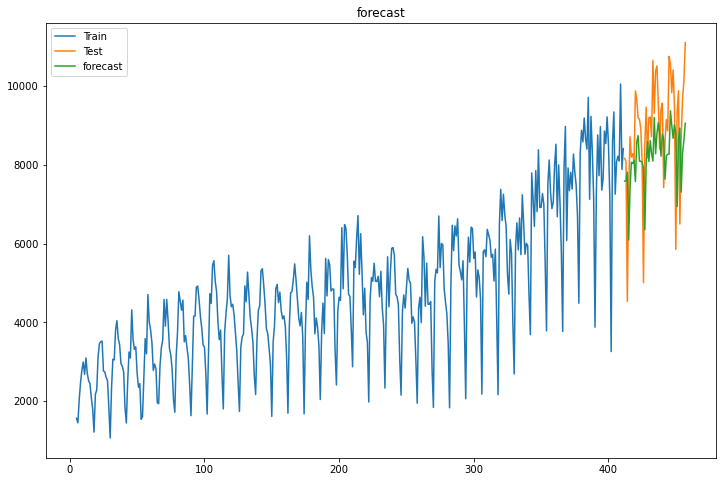

Evaluation metric results:-
MSE is : 2253832.91057054
MAE is : 1242.5723596844537
RMSE is : 1501.2770932011651
MAPE is : 15.237418098061282
R2 is : -0.1856743344035403



In [18]:
pred = model.predict(test_X)
plot()

### 2) Huber Regression
It's loss function combines both L1 and L2 panelty. It is robust to outliers. For more information, https://towardsdatascience.com/generalized-huber-regression-505afaff24c

In [19]:
huber = HuberRegressor().fit(train_X, train_Y)

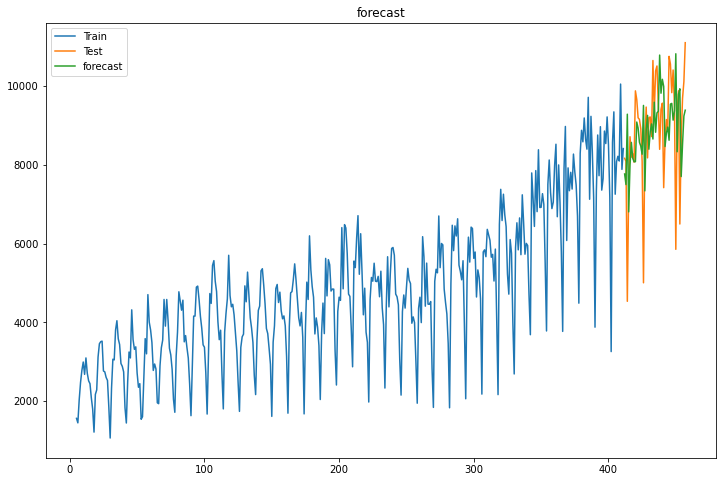

Evaluation metric results:-
MSE is : 2690142.5170172974
MAE is : 1107.7365844429337
RMSE is : 1640.165393189753
MAPE is : 15.030808156987515
R2 is : -0.4152038171754793



In [20]:
pred = huber.predict(test_X)
plot()

### 3) Elastic Net Regression 
It is a hybrid of Ridge and Lasso Regression. For more information, https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29

In [21]:
model = ElasticNet().fit(train_X, train_Y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51695976.88133451, tolerance: 139424.00708255527
  model = cd_fast.enet_coordinate_descent(


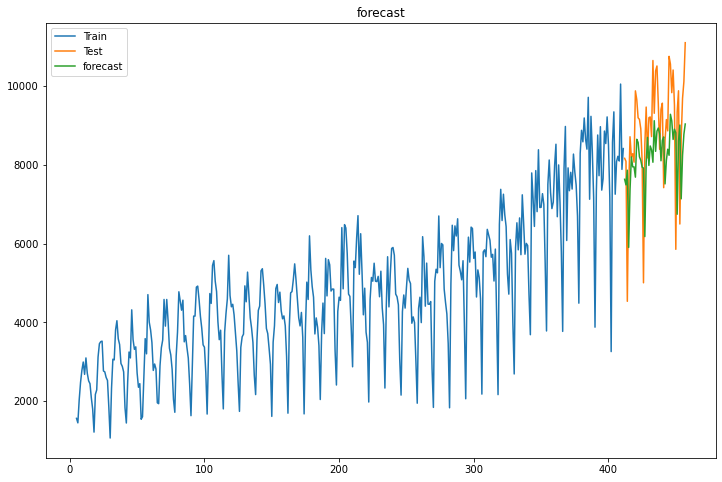

Evaluation metric results:-
MSE is : 2357226.9122469234
MAE is : 1284.0850732421734
RMSE is : 1535.32632109494
MAPE is : 15.738548483800733
R2 is : -0.24006683774485116



In [22]:
pred = model.predict(test_X)
plot()

### 4) Passive Aggressive Regression
The passive-aggressive algorithms are a family of algorithms for large-scale learning. They are similar to the Perceptron in that they do not require a learning rate. However, contrary to the Perceptron, they include a regularization parameter C. For more information, https://jmlr.csail.mit.edu/papers/volume7/crammer06a/crammer06a.pdf

In [23]:
model = PassiveAggressiveRegressor().fit(train_X, train_Y)

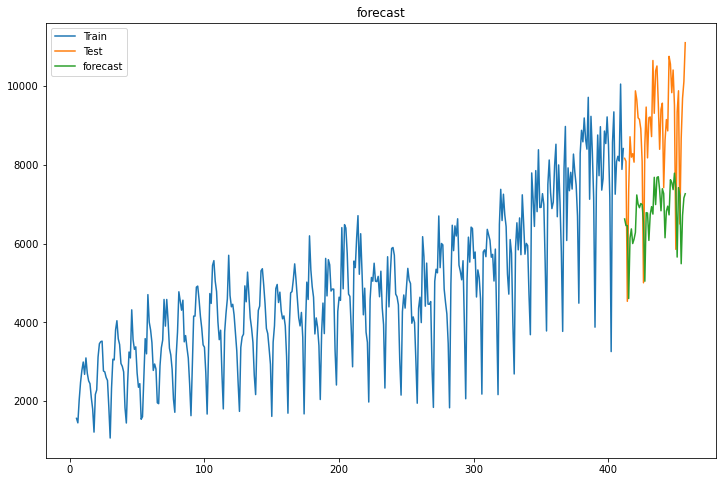

Evaluation metric results:-
MSE is : 6223883.103253788
MAE is : 2345.4497104349716
RMSE is : 2494.771152481483
MAPE is : 26.23078717712292
R2 is : -2.274199440981548



In [24]:
pred = model.predict(test_X)
plot()

### 5) Stochastic Gradient Descent Regression
Stochastic gradient descent is a simple yet very efficient approach to fit linear models. It is particularly useful when the number of samples (and the number of features) is very large. SGD is sensitive to feature scaling. For more information, https://scikit-learn.org/stable/modules/sgd.html#sgd

In [25]:
model = make_pipeline(StandardScaler(), SGDRegressor()).fit(train_X, train_Y)

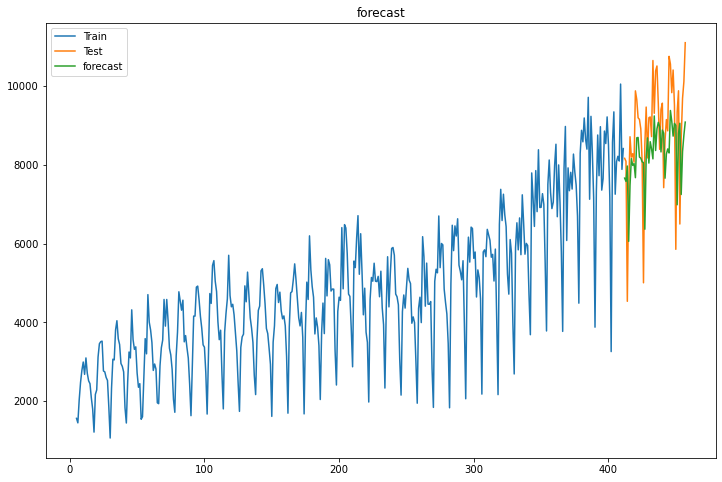

Evaluation metric results:-
MSE is : 2246178.613925518
MAE is : 1222.0066871956578
RMSE is : 1498.7256633305235
MAPE is : 15.151881039501761
R2 is : -0.18164763702178277



In [26]:
pred = model.predict(test_X)
plot()

### 6) Ridge Regression
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization. This estimator has built-in support for multi-variate regression.

In [27]:
model = Ridge().fit(train_X, train_Y)

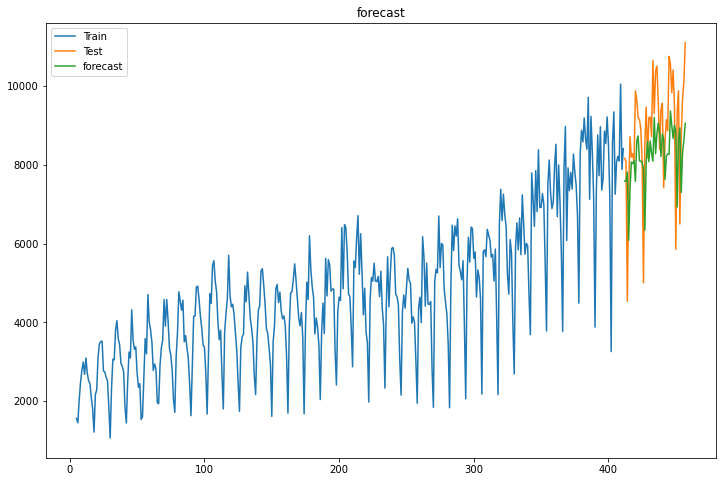

Evaluation metric results:-
MSE is : 2258681.3185483604
MAE is : 1244.5046980711036
RMSE is : 1502.8909869143406
MAPE is : 15.260329766560648
R2 is : -0.18822493736752133



In [28]:
pred = model.predict(test_X)
plot()

### 7) Lasso Regression
Lasso regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The acronym “LASSO” stands for Least Absolute Shrinkage and Selection Operator. For more information, https://www.statisticshowto.com/lasso-regression/

In [29]:
model = linear_model.Lasso().fit(train_X, train_Y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26460367.402656943, tolerance: 139424.00708255527
  model = cd_fast.enet_coordinate_descent(


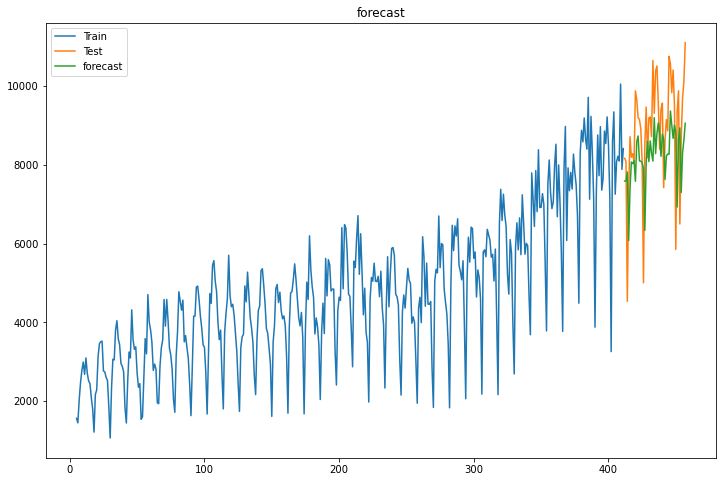

Evaluation metric results:-
MSE is : 2258689.939061637
MAE is : 1244.4385492805304
RMSE is : 1502.8938548885071
MAPE is : 15.260843829224502
R2 is : -0.18822947236268162



In [30]:
pred = model.predict(test_X)
plot()

### 8) LassoLars
 least-angle regression (LARS) is an algorithm for fitting linear regression models to high-dimensional data. For more information, https://en.wikipedia.org/wiki/Least-angle_regression

In [31]:
model = linear_model.LassoLars().fit(train_X, train_Y)

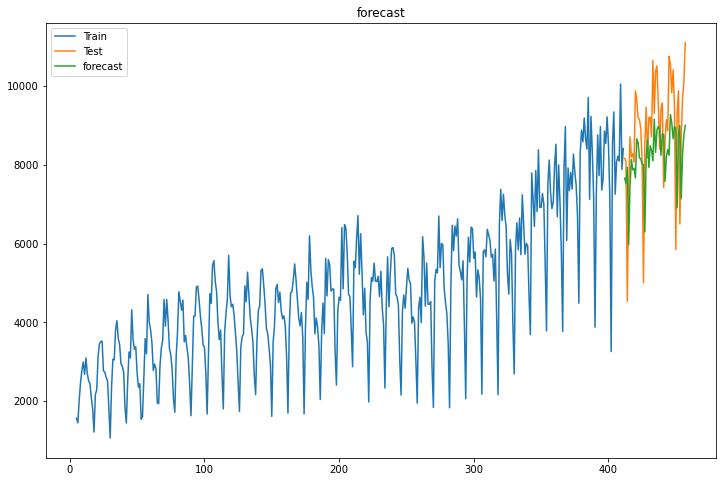

Evaluation metric results:-
MSE is : 2318116.0662724334
MAE is : 1263.969703944238
RMSE is : 1522.536064030154
MAPE is : 15.569259838272643
R2 is : -0.21949178710499528



In [32]:
pred = model.predict(test_X)
plot()